In [18]:
import noise
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import json
%matplotlib notebook

In [2]:
# In a 1024x1024 image, we will create 3 simulated variables in a dictionary named world by using Perlin Noise variables
shape = (60,60)

world={}

# The first variable will represent a 'general' slope (this is actually not the way to proceed, however
# it works as a demonstration)

world['1'] = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world['1'][i][j] = noise.pnoise2(i/200, 
                                    j/200, 
                                    octaves=6, 
                                    persistence=0.5, 
                                    lacunarity=2.0, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=2)
        
# The second variable will represent a resume of the meteorological conditions.
world['2'] = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world['2'][i][j] = noise.pnoise2(i/(150), 
                                    j/(150), 
                                    octaves=3, 
                                    persistence=0.3, 
                                    lacunarity=0.1, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)
        
# Finally the fuel will be represented by this variable. 
world['3'] = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world['3'][i][j] = noise.pnoise2(i, 
                                    j, 
                                    octaves=5, 
                                    persistence=1.1, 
                                    lacunarity=.1, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)


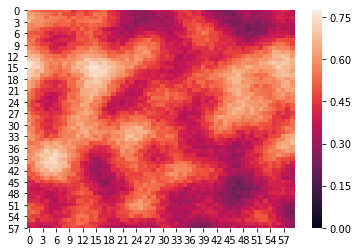

In [3]:
# Instant meteorological conditions:
meteo = world['2']

# Fuel Opportunity:
fuel = world['3']

# Slope direction:
slope = world['1']


# To genrate a probabilty, we must generate a value between 0 and 1 with a combination of the other variables
# therefore we will standarize the representations and then generate a number between 0 and 1 given the conditions. 
worlds = [(world[i]-np.mean(world[i]))/np.std(world[i]) for i in ['1','2','3']]
prob = 1/3*worlds[0]+1/3*worlds[1]+1/3*worlds[2] - .3*np.random.random(shape)
prob = 1/(1+np.exp(-1*prob))
sns.heatmap(prob, vmin=0)

In [6]:
i,j = np.random.choice(shape[0]),np.random.choice(shape[1])
# Create another matrix with the "fire" content

Fire = np.zeros(shape)

Fire[i][j]=1

queue=[(i,j)]
longer = []
prob_time=[]
fire_time=[]
while queue!=[]:
    # Take the first element of the list (remove it and gain the values)
    i,j=queue.pop(0)
    
    if i== 1023 or j==1023 or i==0 or j==0:
        break

    # Fire has (for now 4 closest neighbours to go to)
    if np.random.random() < prob[i+1][j]:
        Fire[i+1][j]=1
        queue.append((i+1,j))
        prob[i+1][j]=0
    if np.random.random() < prob[i][j+1]:
        Fire[i][j+1]=1
        queue.append((i,j+1))
        prob[i][j+1]=0
    if np.random.random() < prob[i-1][j]:
        Fire[i-1][j]=1
        queue.append((i-1,j))
        prob[i-1][j]=0
    if np.random.random() < prob[i][j-1]:
        Fire[i][j-1]=1
        queue.append((i,j-1))
        prob[i-1][j]=0

    queue=set(queue)
    queue=list(queue)
    longer.append(len(queue))
    prob_time.append(prob)
    #fire_time.append([plt.imshow(Fire)])


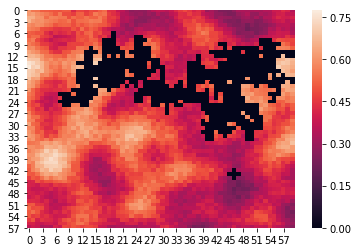

In [7]:
sns.heatmap(prob_time[0])
plt.show()

In [8]:
# Vector to append all the information
all_info = []

# obtain the values
for i in range(1,4):
    try:
        if i<10:
            with open(f"./Datos_meteorologicos/04_21_2012_0{i}_f.json", 'r') as f:
                value = json.load(f)
            all_info.append(value)
        elif i>=10:
            with open(f"./Datos_meteorologicos/04_21_2012_{i}_f.json", 'r') as f:
                value = json.load(f)
            all_info.append(value)
    except:
        pass
        
# Determine geospacial delimitations for the Primavera Forest 


# Delimitation coordinates
lat1, lon1 = 20.730654, -103.684725
lat2, lon2 = 20.536931, -103.684725
lat3, lon3 = 20.536931, -103.449552
lat4, lon4 = 20.730654, -103.449552

#Polygon
del_lat = [lat1,lat2,lat3,lat4]
del_lon = [lon1,lon2,lon3,lon4]

# Generate a grid for the data points:
lat_numbers = 60
lon_numbers = 60
lat_vector = np.linspace(min(del_lat), max(del_lat), lat_numbers)
lon_vector = np.linspace(min(del_lon), max(del_lon), lon_numbers)

# Meshgrid with the values
lon,lat = np.meshgrid(lon_vector,lat_vector)

# Have all the coordinates in a vector and in a dataframe
coordinates = [[lat,lon] for lat in lat_vector for lon in lon_vector]
coordinates_df = pd.DataFrame(coordinates, columns=['latitude','longitude'])

# Generate a list that will contain the dataframes
information0 = []

# Add latitude, longitude and time (hour), and then information
for alpha in range(len(all_info)):
    try:
        information = pd.DataFrame([all_info[alpha][i]['currently'] for i in range(len(all_info[0]))])
        information['longitude'] = coordinates_df.longitude
        information['latitude'] = coordinates_df.latitude
        information['time_alpha']= (alpha+1)*np.ones(3600)
        information0.append(information)
    except:
        pass

# Concatenate all the dataframes
information = pd.concat(information0, ignore_index=True)

/home/dhdzmota/.local/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
temperature = [np.array(np.split(np.array([all_info[alpha][i]['currently']['temperature'] for i in range(len(all_info[0]))]),60)) for alpha in range(len(all_info))]
temperature1 = list(reversed(temperature[2]))
windspeed = [np.array(np.split(np.array([all_info[alpha][i]['currently']['windSpeed'] for i in range(len(all_info[0]))]),60)) for alpha in range(len(all_info))]
windspeed1= list(reversed(windspeed[1]))
#fig=plt.figure()

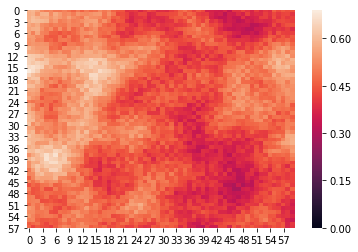

In [11]:
# Instant meteorological conditions:
meteo = world['2']

# Fuel Opportunity:
fuel = world['3']

# Slope direction:
slope = world['1']


# To genrate a probabilty, we must generate a value between 0 and 1 with a combination of the other variables
# therefore we will standarize the representations and then generate a number between 0 and 1 given the conditions. 
worlds = [(world[i]-np.mean(world[i]))/np.std(world[i]) for i in ['1','2','3']]
prob = 1/3*(temperature1-np.mean(temperature1))/np.std(temperature) + 1/6*worlds[0]+1/6*worlds[1]+1/6*worlds[2] - .3*np.random.random(shape)
prob = 1/(1+np.exp(-1*prob))
fig=plt.figure()
sns.heatmap(prob, vmin=0)

In [16]:
i,j = np.random.choice(shape[0]-1),np.random.choice(shape[1]-1)
# Create another matrix with the "fire" content

Fire = np.zeros(shape)
print(i,j)

Fire[i][j]=1

queue=[(i,j)]
longer = []
prob_time=[]
fire_time=[]
while queue!=[]:
    # Take the first element of the list (remove it and gain the values)
    i,j=queue.pop(0)
    
    if i== shape[0] or j==shape[1] or i==0 or j==0:
        break

    # Fire has (for now 4 closest neighbours to go to)
    if np.random.random() < prob[i+1][j]:
        Fire[i+1][j]=1
        queue.append((i+1,j))
        prob[i+1][j]=0
    if np.random.random() < prob[i][j+1]:
        Fire[i][j+1]=1
        queue.append((i,j+1))
        prob[i][j+1]=0
    if np.random.random() < prob[i-1][j]:
        Fire[i-1][j]=1
        queue.append((i-1,j))
        prob[i-1][j]=0
    if np.random.random() < prob[i][j-1]:
        Fire[i][j-1]=1
        queue.append((i,j-1))
        prob[i-1][j]=0

    queue=set(queue)
    queue=list(queue)
    longer.append(len(queue))
    prob_time.append(prob)
    #fire_time.append([plt.imshow(Fire)])


18 9


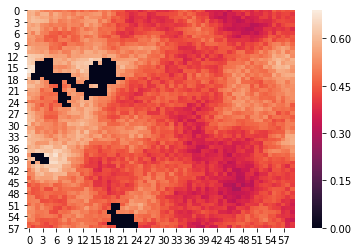

In [17]:
fig=plt.figure()
sns.heatmap(prob_time[0])
plt.show()